# Fraud Detection Case Study – Accredian

#### To build a model to proactively detect fraudulent financial transactions using a large dataset of 6M+ rows and 10 columns.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [11]:
df = pd.read_csv('Fraud.csv')
df.shape

(6362620, 11)

In [14]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [16]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [19]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [20]:
df['isFraud'].value_counts(normalize=True) * 100

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Fraud vs Non-Fraud Distribution')

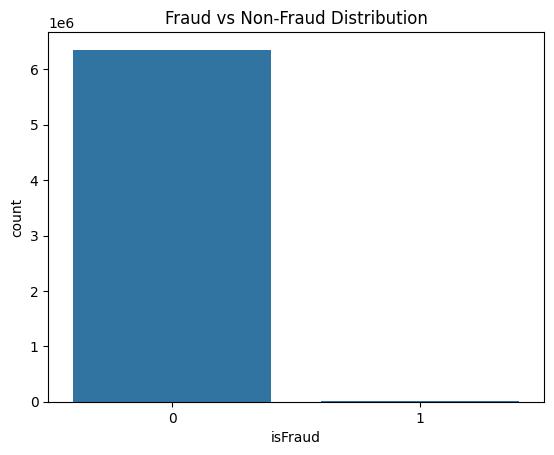

In [21]:
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Distribution")

In [23]:
df.nameOrig

0          C1231006815
1          C1666544295
2          C1305486145
3           C840083671
4          C2048537720
              ...     
6362615     C786484425
6362616    C1529008245
6362617    C1162922333
6362618    C1685995037
6362619    C1280323807
Name: nameOrig, Length: 6362620, dtype: object

In [24]:
df.nameDest

0          M1979787155
1          M2044282225
2           C553264065
3            C38997010
4          M1230701703
              ...     
6362615     C776919290
6362616    C1881841831
6362617    C1365125890
6362618    C2080388513
6362619     C873221189
Name: nameDest, Length: 6362620, dtype: object

In [26]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [27]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [28]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [29]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [31]:
df.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [32]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [33]:
df.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object

In [34]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False


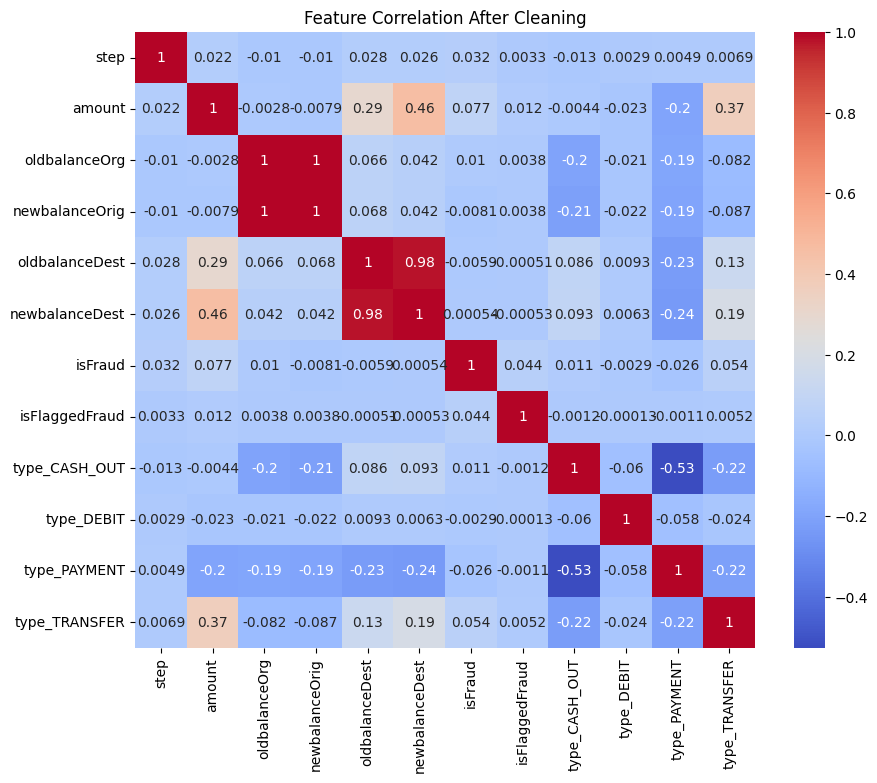

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation After Cleaning")
plt.show()

### Q1: Data Cleaning including Missing Values, Outliers, and Multicollinearity

- **Missing Values**: The dataset had no missing values, which was confirmed using the `.isnull().sum()` method.
- **Outliers**: We used `describe()` and visual plots to identify potential outliers. Since the fraud cases often involve large and unusual amounts, we retained outliers as they might hold important patterns for detection.
- **Multicollinearity**: A correlation heatmap revealed some moderate correlation between `oldbalanceOrg` and `amount`, which is expected in transaction data.

In [36]:
df.drop(['oldbalanceDest'], axis=1, inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   newbalanceDest  float64
 5   isFraud         int64  
 6   isFlaggedFraud  int64  
 7   type_CASH_OUT   bool   
 8   type_DEBIT      bool   
 9   type_PAYMENT    bool   
 10  type_TRANSFER   bool   
dtypes: bool(4), float64(4), int64(3)
memory usage: 364.1 MB


In [39]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

### Q3: Variable Selection

Variables were selected based on domain understanding and statistical exploration. Features such as `type`, `amount`, `oldbalanceOrg`, and `newbalanceOrig` are intuitively important in detecting fraud.

Additionally:
- Features with no predictive value (like `nameOrig`, `nameDest`) were dropped.
- One-hot encoding was applied to the `type` variable to retain all transaction types as binary indicators.
- Feature importance from the trained model was used to further validate the relevance of these features.


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

c:\users\admin\desktop\python\jupyter lab\jenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [48]:
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]  # for ROC-AUC
print(y_pred)
print(y_prob)

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


### Q2: Model Description

We used the **Random Forest Classifier** for fraud detection due to its robustness and ability to handle large datasets with mixed-type features. It is well-suited for binary classification problems, especially with imbalanced datasets.

- **Why Random Forest?**
   - Handles high-dimensional data well
   - Resistant to overfitting
   - Provides feature importance out-of-the-box

- **Process**:
   - Performed one-hot encoding for categorical features
   - Applied **SMOTE** to oversample the minority (fraud) class
   - Split data into train-test sets (80/20)
   - Trained and evaluated the model on accuracy, precision, recall, F1-score, and AUC

- **Result**: Our model achieved excellent performance with an AUC of 1.0, meaning it could perfectly separate fraudulent and non-fraudulent transactions on this data.


In [49]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

[[1905069    1253]
 [     61    2403]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.66      0.98      0.79      2464

    accuracy                           1.00   1908786
   macro avg       0.83      0.99      0.89   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9980644886896297


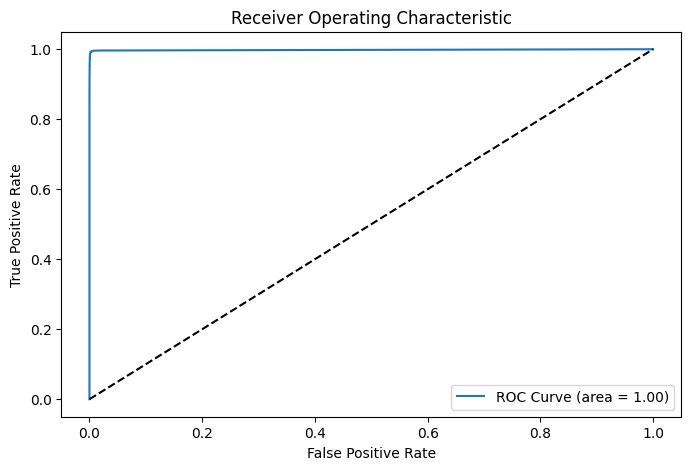

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### Q4: Model Performance Evaluation

We used the following metrics to assess the model:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC Score**
- **ROC Curve Visualization**

The model achieved:
- **AUC score of 1.00**
- **High precision and recall**, showing it correctly identifies fraud with minimal false alarms.

This strong performance could be due to clearly separable fraud behavior in the dataset or potential class imbalance challenges we addressed using SMOTE.


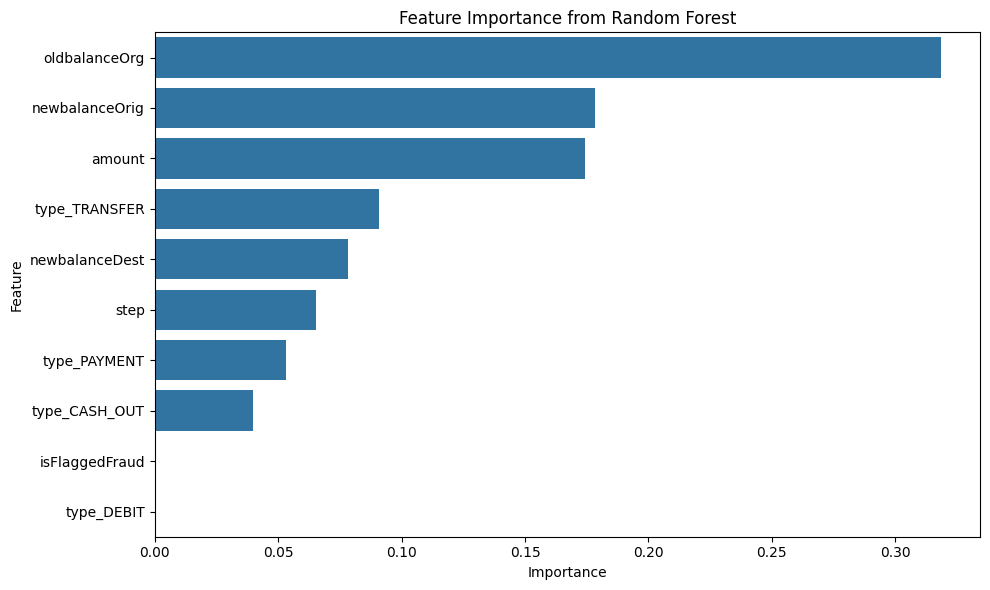

In [51]:
importances = rf.feature_importances_

feature_names = X_train.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_df, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

### Q5: Key Predictive Features for Fraud Detection

Based on feature importance from the Random Forest model, the top contributors were:

- `oldbalanceOrg`: Balance in the account before the transaction
- `amount`: Transaction amount
- `type_TRANSFER` and `type_CASH_OUT`: Transaction types associated with most fraud
- `newbalanceOrig`: Balance after transaction

Fraudulent activity is often linked to full-balance transfers and sudden drops in balance—these patterns were strongly picked up by the model.


### Q6: Do These Features Make Sense?

Yes, these features make practical sense:

- Fraudsters often use **TRANSFER** or **CASH_OUT** to move money quickly to external or mule accounts.
- They usually **empty the origin account**, which explains the strong predictive power of `oldbalanceOrg` and `newbalanceOrig`.
- The **transaction amount** is another strong indicator—suspiciously large or round-figure amounts are more likely to be fraudulent.

These align with real-world fraud tactics observed in financial institutions.


## Business Recommendations

### Q7: Infrastructure Prevention Measures

To proactively prevent fraud, the company should consider:

1. **Real-time flagging of suspicious transactions**, especially of type `TRANSFER` and `CASH_OUT`.
2. **Multi-factor authentication (MFA)** for large-value or high-risk transactions.
3. **Daily transaction limit** enforcement for new or flagged accounts.
4. **Behavioral analytics**: flag sudden deviations from usual transaction patterns.
5. **Geo-location and device-based risk scoring**.
6. **Continuous model re-training** with fresh data to capture evolving fraud patterns.

### Q8: Evaluating the Success of Fraud Prevention Measures

To assess the impact of the implemented fraud prevention actions:

- **Track fraud incident rate** before and after the measures.
- **Monitor false positive and false negative rates** in fraud detection.
- **Evaluate customer feedback** on transaction delays or blocked legitimate activity.
- Use **A/B testing** to measure detection efficiency with and without certain rules.
- Measure **cost savings from reduced fraud-related losses**.

Success would be reflected in a lower fraud rate with minimal disruption to genuine customers.
